In [396]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import dabl
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import joblib
import shap
import PIL
from PIL import Image

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [397]:
# import the dataset
df = pd.read_csv("RTA Dataset.csv")

In [398]:
df.head()

,Time,Day_of_week,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Service_year_of_vehicle,...,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity
0,17:02:00,Monday,18-30,Male,Above high school,Employee,1-2yr,Automobile,Owner,Above 10yr,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury
1,17:02:00,Monday,31-50,Male,Junior high school,Employee,Above 10yr,Public (> 45 seats),Owner,5-10yrs,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury
2,17:02:00,Monday,18-30,Male,Junior high school,Employee,1-2yr,Lorry (41?100Q),Owner,NaN,...,Going straight,Driver or rider,Male,31-50,3,Driver,NaN,Not a Pedestrian,Changing lane to the left,Serious Injury
3,1:06:00,Sunday,18-30,Male,Junior high school,Employee,5-10yr,Public (> 45 seats),Governmental,NaN,...,Going straight,Pedestrian,Female,18-30,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury
4,1:06:00,Sunday,18-30,Male,Junior high school,Employee,2-5yr,NaN,Owner,5-10yrs,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury


In [399]:
df.replace("Unknown", np.nan, inplace=True)
df.to_csv('modified_dataset.csv', index=False)

In [400]:
df.replace("Other", np.nan, inplace=True)
df.to_csv('modified_dataset.csv', index=False)

## EDA VISUALIZATION

In [401]:
# print the dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12316 entries, 0 to 12315
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Time                         12316 non-null  object
 1   Day_of_week                  12316 non-null  object
 2   Age_band_of_driver           10768 non-null  object
 3   Sex_of_driver                12138 non-null  object
 4   Educational_level            11475 non-null  object
 5   Vehicle_driver_relation      11600 non-null  object
 6   Driving_experience           11487 non-null  object
 7   Type_of_vehicle              10158 non-null  object
 8   Owner_of_vehicle             11812 non-null  object
 9   Service_year_of_vehicle      5505 non-null   object
 10  Defect_of_vehicle            7889 non-null   object
 11  Area_accident_occured        8236 non-null   object
 12  Lanes_or_Medians             11874 non-null  object
 13  Road_allignment              12

In [402]:
# find the number of missing values present in each column
df.isnull().sum()

Time                              0
Day_of_week                       0
Age_band_of_driver             1548
Sex_of_driver                   178
Educational_level               841
Vehicle_driver_relation         716
Driving_experience              829
Type_of_vehicle                2158
Owner_of_vehicle                504
Service_year_of_vehicle        6811
Defect_of_vehicle              4427
Area_accident_occured          4080
Lanes_or_Medians                442
Road_allignment                 142
Types_of_Junction              1523
Road_surface_type               339
Road_surface_conditions           0
Light_conditions                  0
Weather_conditions              588
Type_of_collision               195
Number_of_vehicles_involved       0
Number_of_casualties              0
Vehicle_movement               1333
Casualty_class                    0
Sex_of_casualty                   0
Age_band_of_casualty              0
Casualty_severity                 0
Work_of_casuality           

Accident_severity
Slight Injury     10415
Serious Injury     1743
Fatal injury        158
Name: count, dtype: int64


<Axes: xlabel='Accident_severity'>

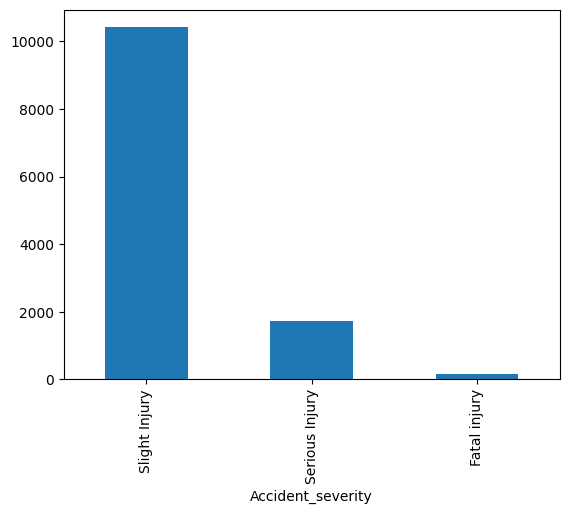

In [403]:
# target variable classes counts and bar plot
print(df['Accident_severity'].value_counts())
df['Accident_severity'].value_counts().plot(kind='bar')

<Axes: xlabel='Educational_level'>

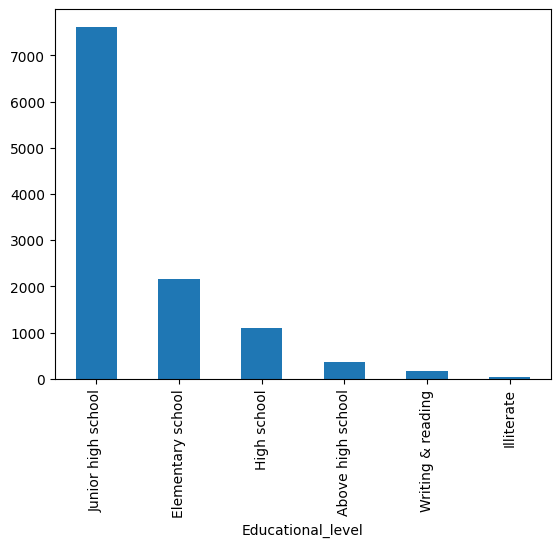

In [404]:
# Education levels of car drivers
df['Educational_level'].value_counts().plot(kind='bar')

c:\Users\justi\AppData\Local\Programs\Python\Python312\Lib\site-packages\dabl\preprocessing.py:172: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(series[:10])
c:\Users\justi\AppData\Local\Programs\Python\Python312\Lib\site-packages\dabl\preprocessing.py:177: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(series)
c:\Users\justi\AppData\Local\Programs\Python\Python312\Lib\site-packages\dabl\preprocessing.py:172: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(series[:10])
c:\Users\justi\AppData\Local\Programs\Python\Python312\Lib\site

Target looks like classification
Showing only top 10 of 32 categorical features


[<Axes: title={'center': 'Target distribution'}, xlabel='count', ylabel='Accident_severity'>,
 None,
 array([[<Axes: title={'center': 'Number_of_vehicles_involved'}>,
         <Axes: title={'center': 'Number_of_casualties'}>,
         <Axes: title={'center': 'Age_band_of_driver'}>,
         <Axes: title={'center': 'Types_of_Junction'}>,
         <Axes: title={'center': 'Type_of_vehicle'}>],
        [<Axes: title={'center': 'Weather_conditions'}>,
         <Axes: title={'center': 'Cause_of_accident'}>,
         <Axes: title={'center': 'Day_of_week'}>,
         <Axes: title={'center': 'Area_accident_occured'}>,
         <Axes: title={'center': 'Light_conditions'}>]], dtype=object)]

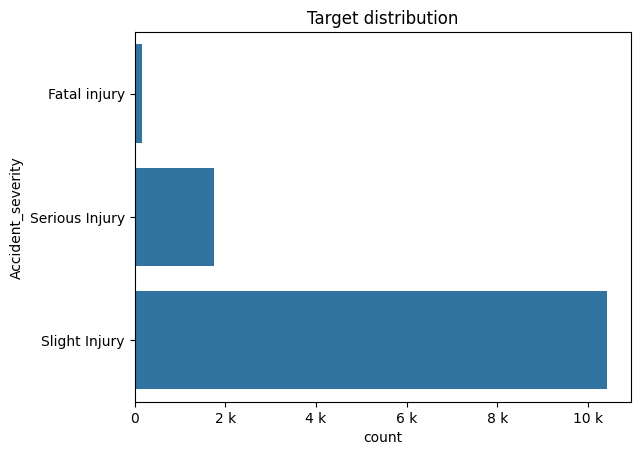

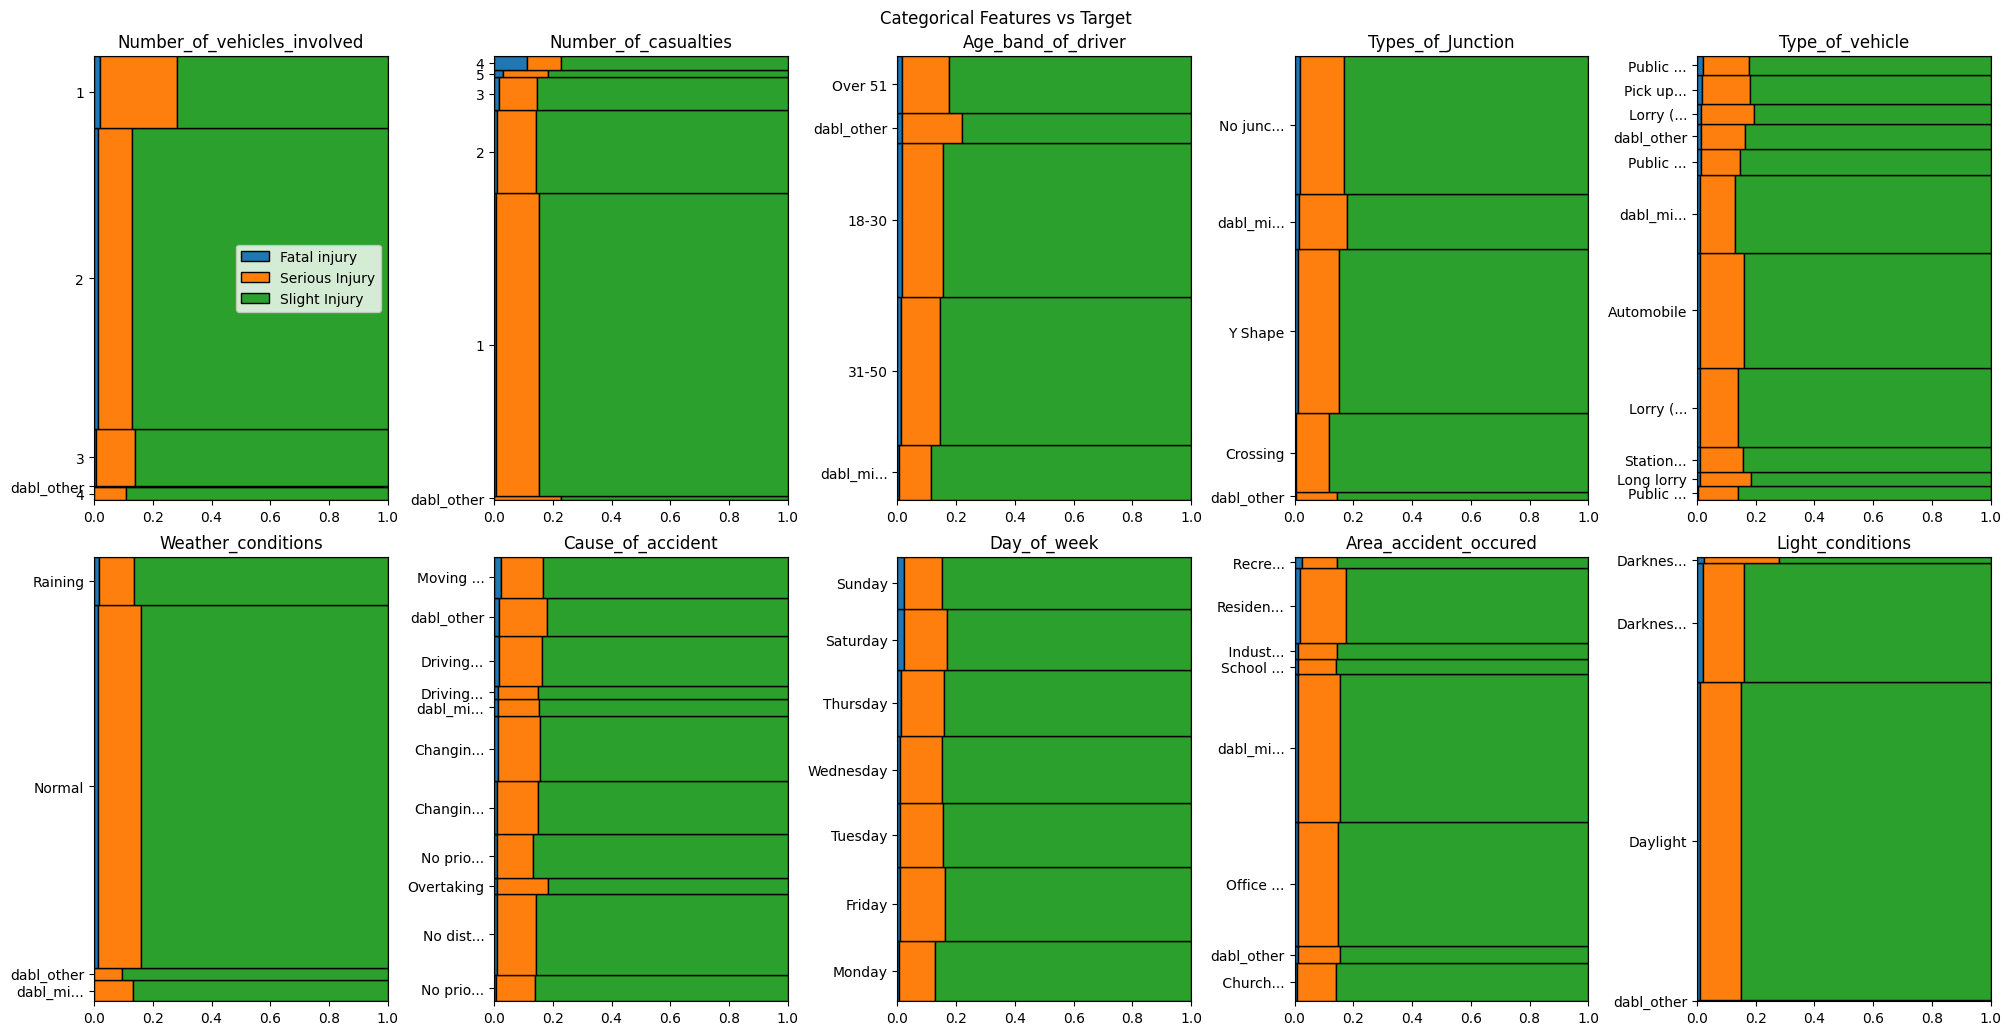

In [405]:
# visualizing dataset using dabl library
dabl.plot(df, target_col='Accident_severity')

<function matplotlib.pyplot.show(close=None, block=None)>

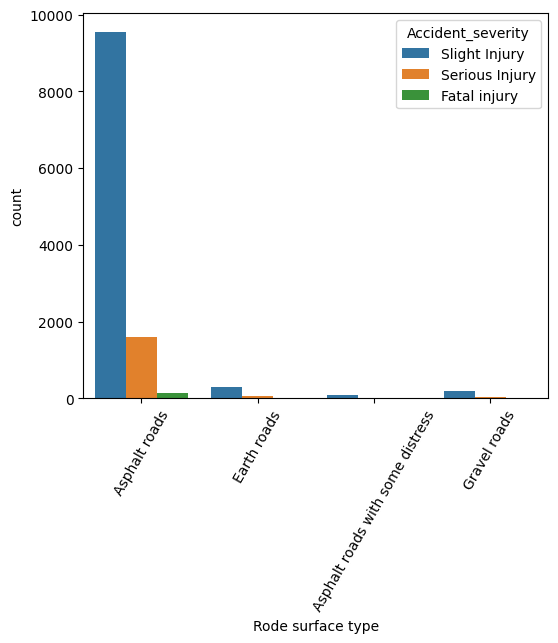

In [406]:
# plot the bar plot of road_surface_type and accident severity feature
plt.figure(figsize=(6,5))
sns.countplot(x='Road_surface_type', hue='Accident_severity', data=df)
plt.xlabel('Rode surface type')
plt.xticks(rotation=60)
plt.show

**Data Preparation**

In [407]:
# convert object type column into datetime datatype column
df['Time'] = pd.to_datetime(df['Time'])

# Extrating 'Hour_of_Day' feature from the Time column
new_df = df.copy()
new_df['Hour_of_Day'] = new_df['Time'].dt.hour
n_df = new_df.drop('Time', axis=1)
n_df.head()

C:\Users\justi\AppData\Local\Temp\ipykernel_11564\921621956.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'])


,Day_of_week,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Service_year_of_vehicle,Defect_of_vehicle,...,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity,Hour_of_Day
0,Monday,18-30,Male,Above high school,Employee,1-2yr,Automobile,Owner,Above 10yr,No defect,...,na,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury,17
1,Monday,31-50,Male,Junior high school,Employee,Above 10yr,Public (> 45 seats),Owner,5-10yrs,No defect,...,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury,17
2,Monday,18-30,Male,Junior high school,Employee,1-2yr,Lorry (41?100Q),Owner,NaN,No defect,...,Driver or rider,Male,31-50,3,Driver,NaN,Not a Pedestrian,Changing lane to the left,Serious Injury,17
3,Sunday,18-30,Male,Junior high school,Employee,5-10yr,Public (> 45 seats),Governmental,NaN,No defect,...,Pedestrian,Female,18-30,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury,1
4,Sunday,18-30,Male,Junior high school,Employee,2-5yr,NaN,Owner,5-10yrs,No defect,...,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury,1


In [408]:
obj_cols = [col for col in df.columns if df[col].dtypes == 'object']
obj_cols2 = [col for col in obj_cols if col != 'Accident_severity']
obj_cols2

['Day_of_week',
 'Age_band_of_driver',
 'Sex_of_driver',
 'Educational_level',
 'Vehicle_driver_relation',
 'Driving_experience',
 'Type_of_vehicle',
 'Owner_of_vehicle',
 'Service_year_of_vehicle',
 'Defect_of_vehicle',
 'Area_accident_occured',
 'Lanes_or_Medians',
 'Road_allignment',
 'Types_of_Junction',
 'Road_surface_type',
 'Road_surface_conditions',
 'Light_conditions',
 'Weather_conditions',
 'Type_of_collision',
 'Vehicle_movement',
 'Casualty_class',
 'Sex_of_casualty',
 'Age_band_of_casualty',
 'Casualty_severity',
 'Work_of_casuality',
 'Fitness_of_casuality',
 'Pedestrian_movement',
 'Cause_of_accident']

C:\Users\justi\AppData\Local\Temp\ipykernel_11564\939094877.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(5,5))


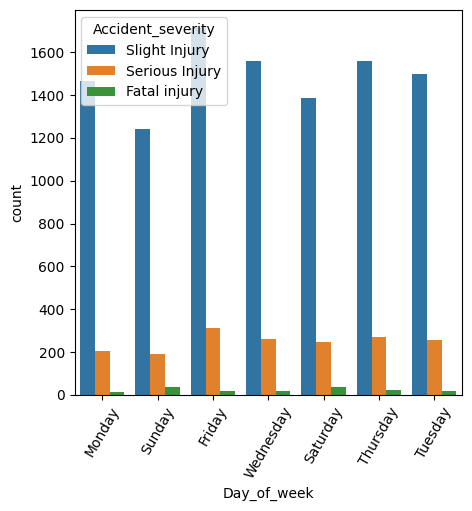

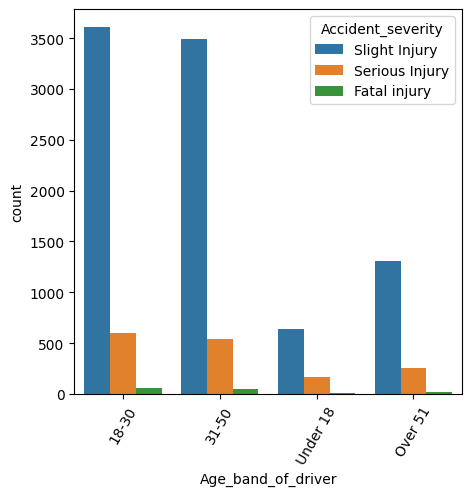

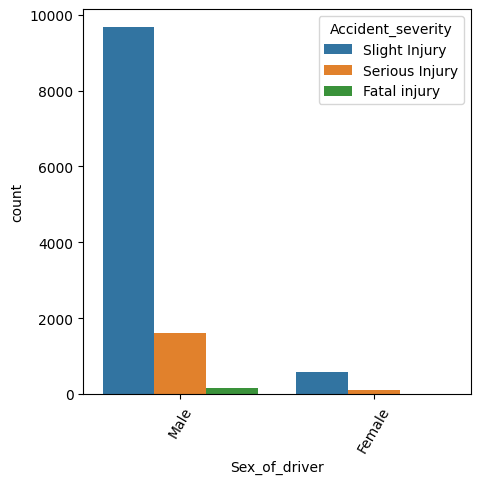

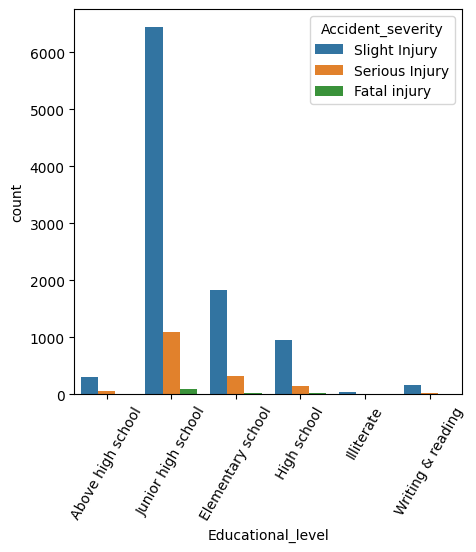

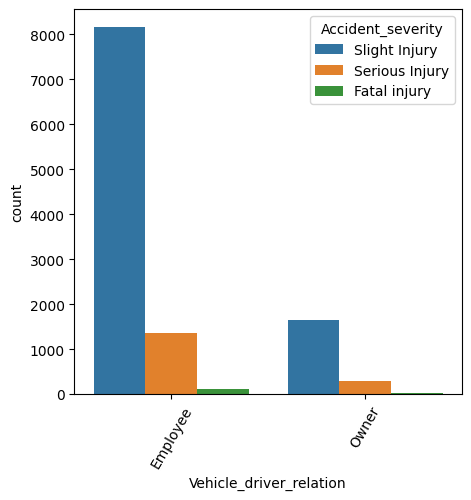

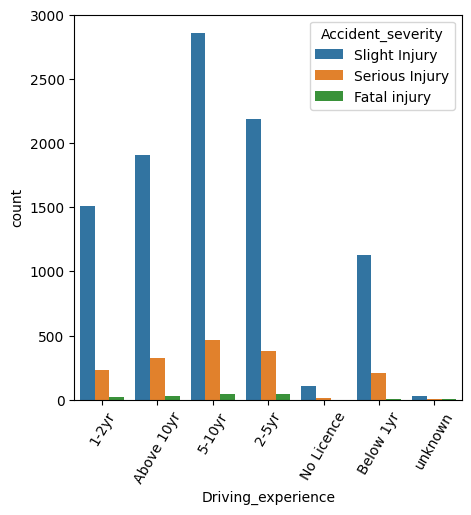

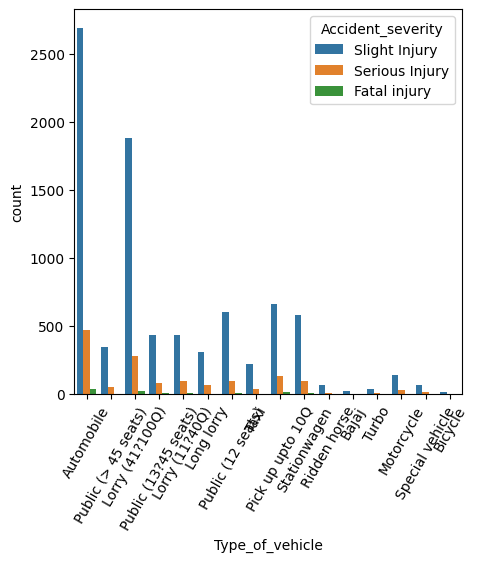

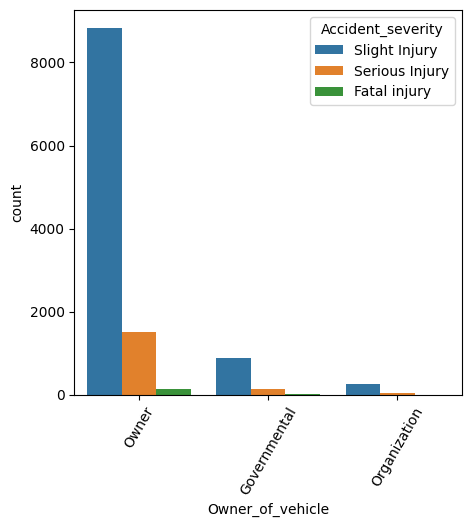

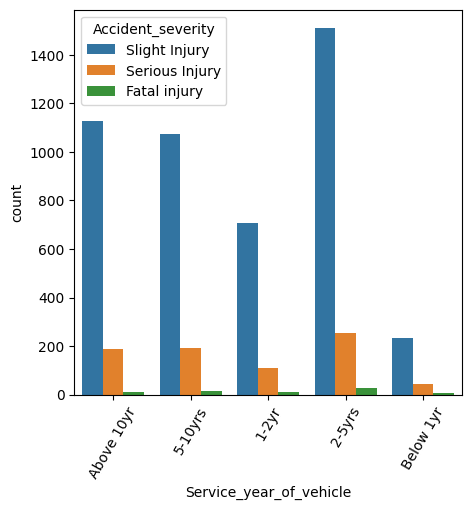

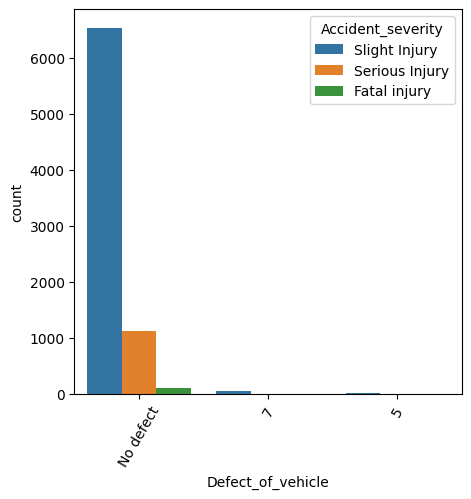

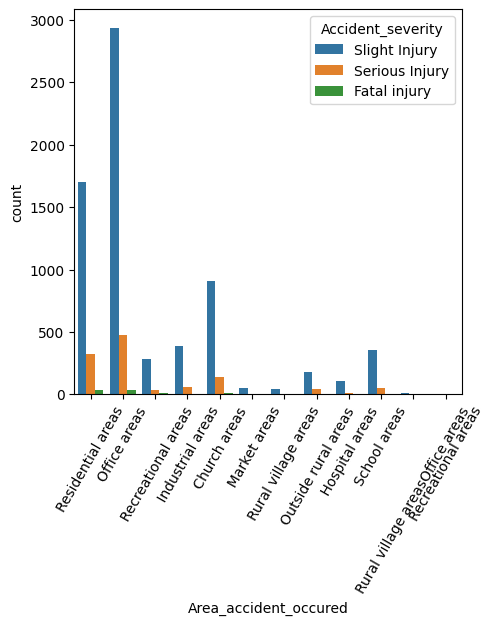

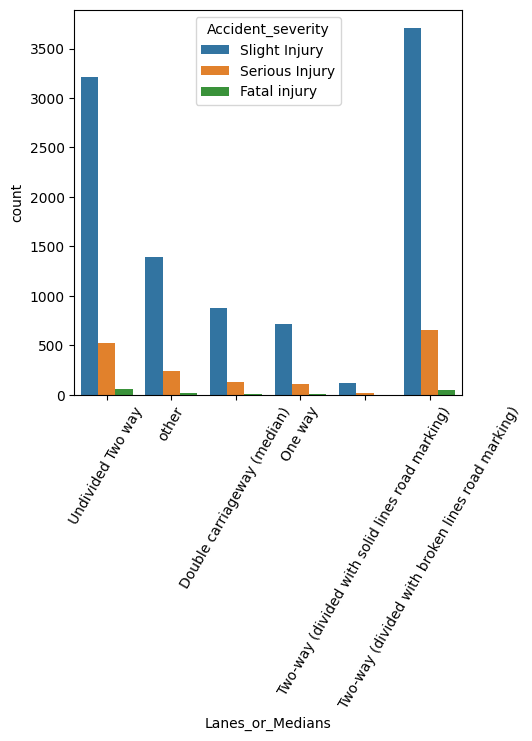

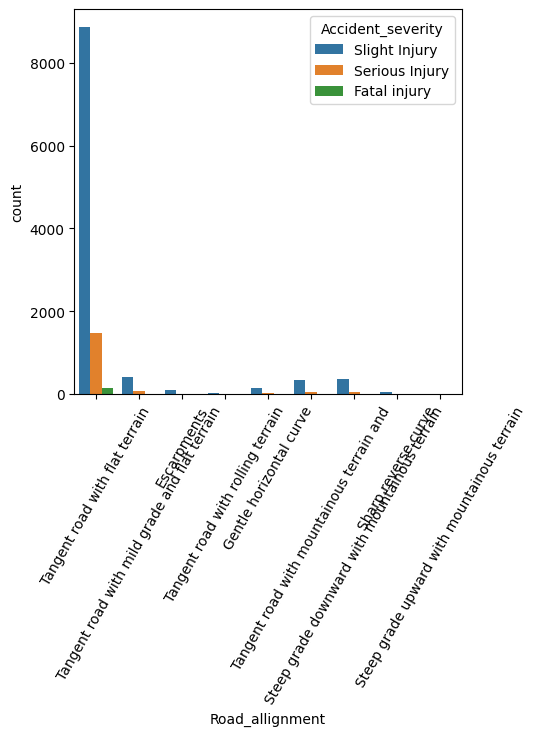

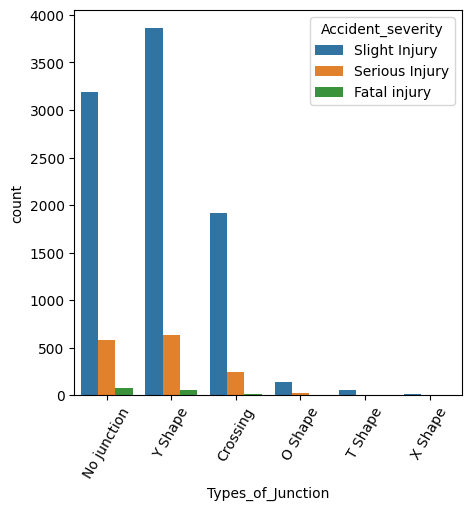

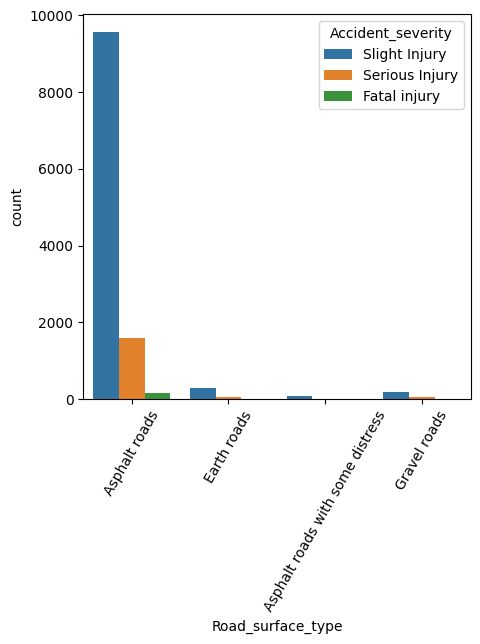

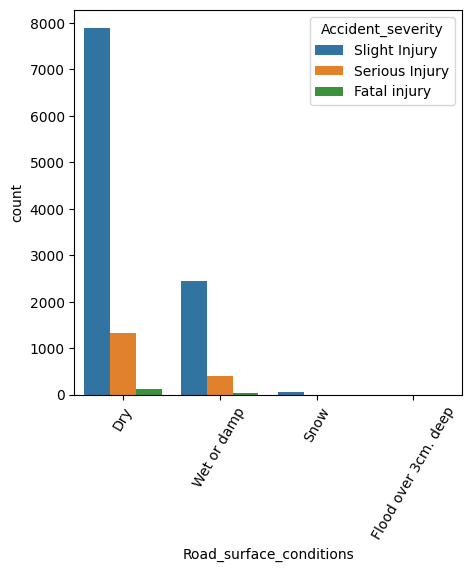

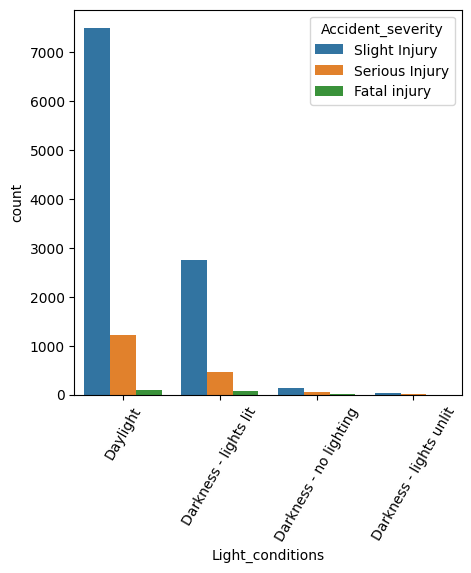

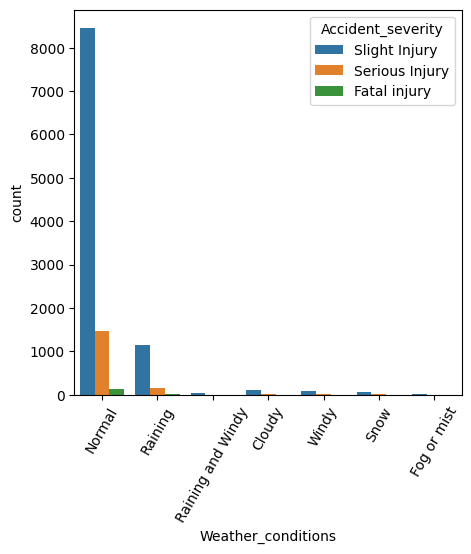

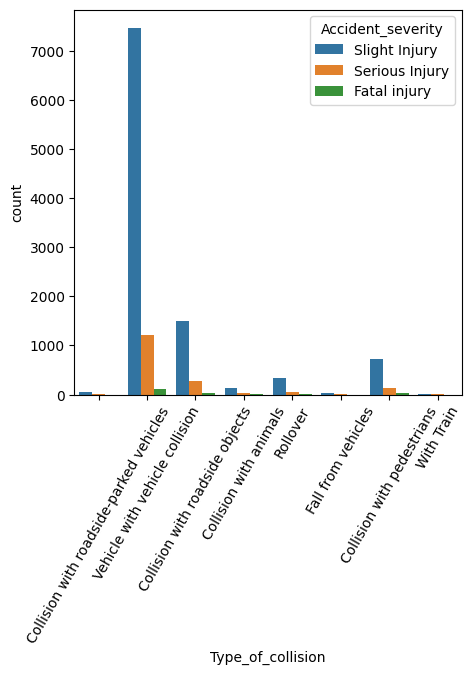

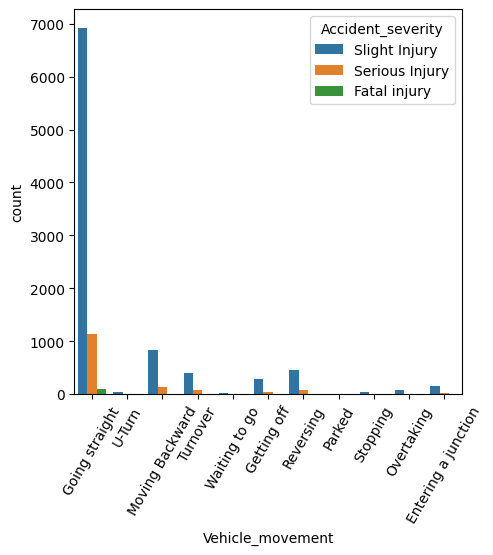

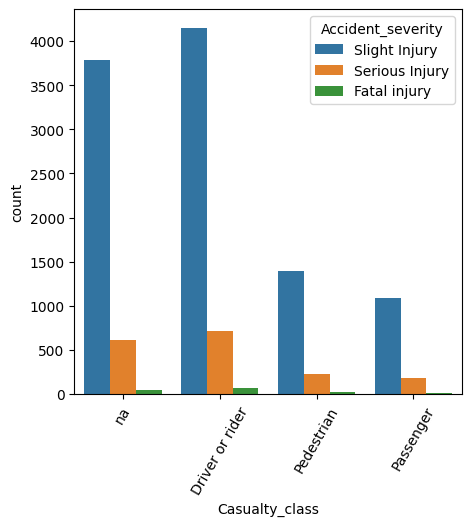

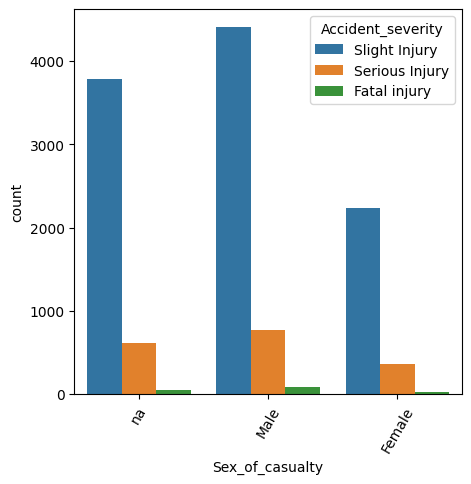

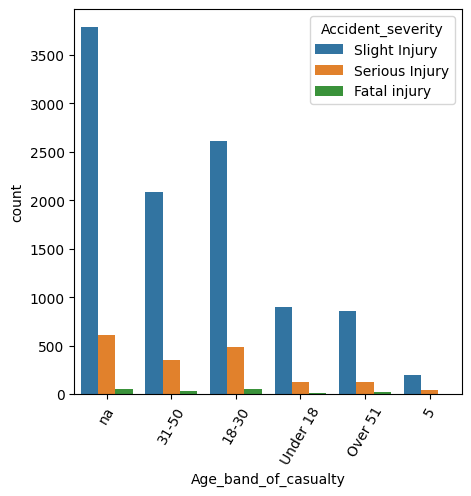

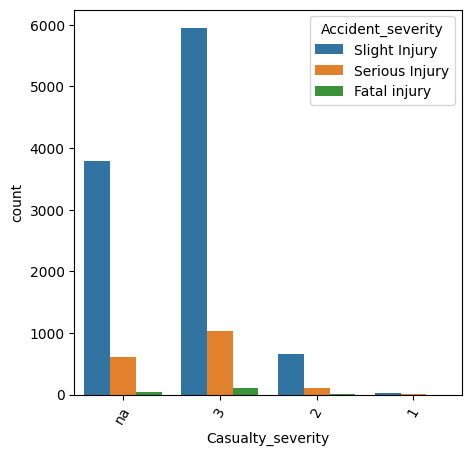

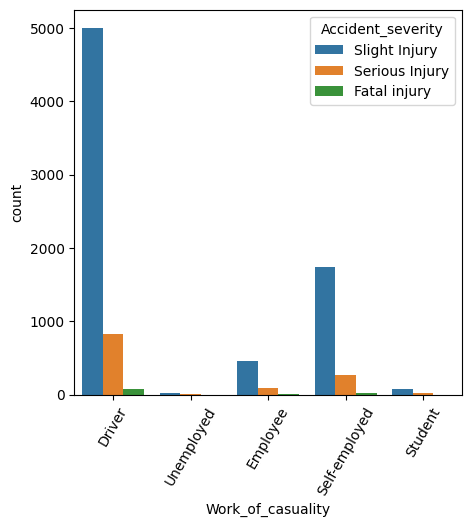

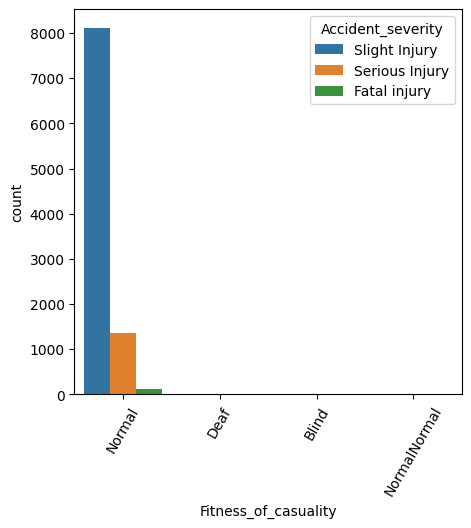

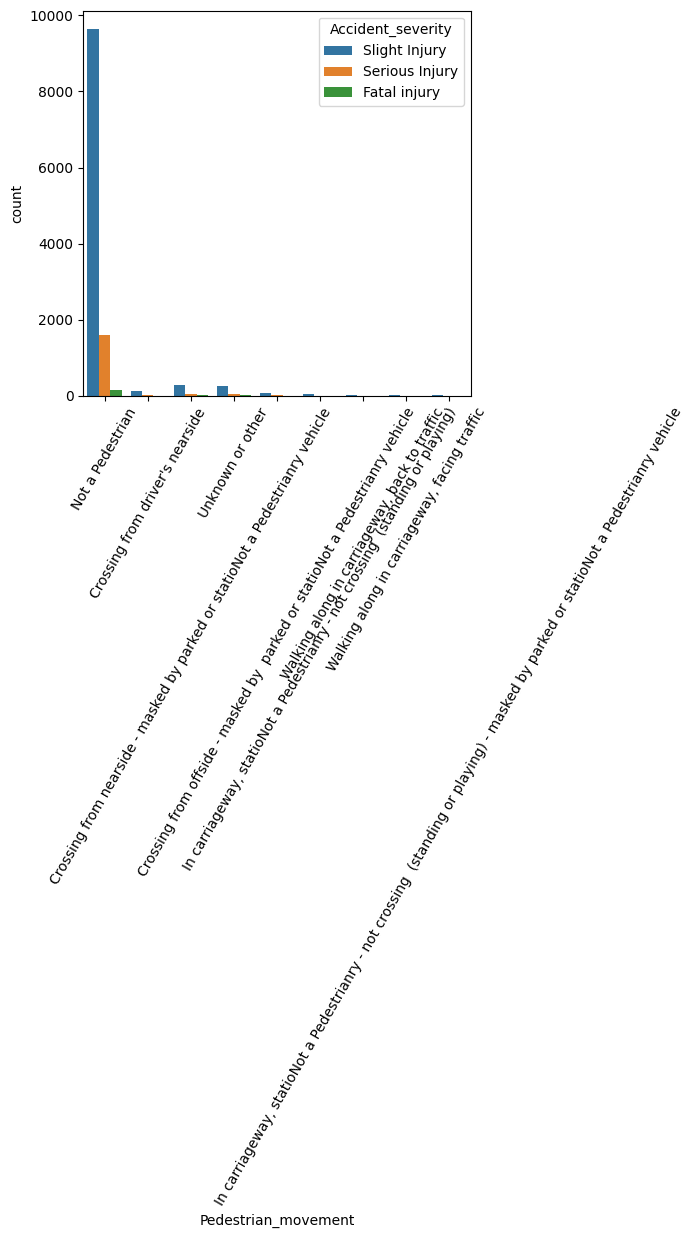

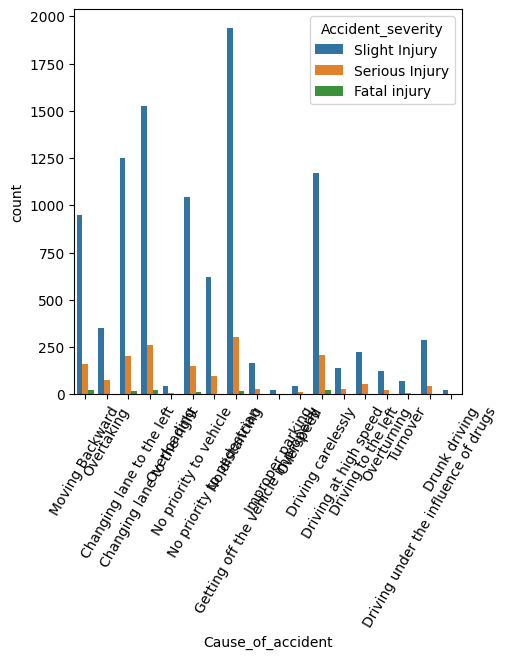

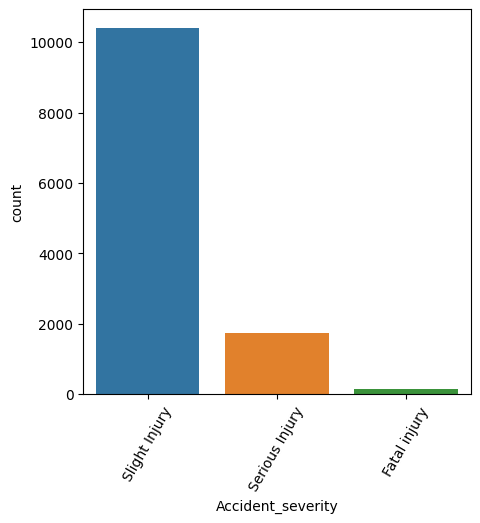

In [409]:
# data visualization of categorical cols

def count_plot(col):
    n_df[col].value_counts()
    
    # plot the figure of count plot
    plt.figure(figsize=(5,5))
    sns.countplot(x=col, hue='Accident_severity', data=n_df)
    plt.xlabel(f'{col}')
    plt.xticks(rotation=60)
    plt.show
    
for col in obj_cols:
    count_plot(col)

## DATA PREPROCESSING

In [410]:
# feature selection based on visualization (to_be_continue)
features = ['Day_of_week','Number_of_vehicles_involved','Number_of_casualties','Area_accident_occured',
           'Types_of_Junction','Age_band_of_driver','Sex_of_driver','Educational_level',
           'Vehicle_driver_relation','Type_of_vehicle','Driving_experience','Service_year_of_vehicle','Type_of_collision',
           'Sex_of_casualty','Age_band_of_casualty','Cause_of_accident','Hour_of_Day']
len(features)

17

In [411]:
# new dataframe generated
featureset_df = n_df[features]
target = n_df['Accident_severity']

In [412]:
# meta data of the new sub dataset
featureset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12316 entries, 0 to 12315
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Day_of_week                  12316 non-null  object
 1   Number_of_vehicles_involved  12316 non-null  int64 
 2   Number_of_casualties         12316 non-null  int64 
 3   Area_accident_occured        8236 non-null   object
 4   Types_of_Junction            10793 non-null  object
 5   Age_band_of_driver           10768 non-null  object
 6   Sex_of_driver                12138 non-null  object
 7   Educational_level            11475 non-null  object
 8   Vehicle_driver_relation      11600 non-null  object
 9   Type_of_vehicle              10158 non-null  object
 10  Driving_experience           11487 non-null  object
 11  Service_year_of_vehicle      5505 non-null   object
 12  Type_of_collision            12121 non-null  object
 13  Sex_of_casualty              12

## MISSING VALUE TREATMENT

In [413]:
feature_df = featureset_df.copy()

In [414]:
df[['Service_year_of_vehicle']].value_counts()

Service_year_of_vehicle
2-5yrs                     1792
Above 10yr                 1324
5-10yrs                    1280
1-2yr                       827
Below 1yr                   282
Name: count, dtype: int64

In [415]:
df[['Types_of_Junction']].value_counts()

Types_of_Junction
Y Shape              4543
No junction          3837
Crossing             2177
O Shape               164
T Shape                60
X Shape                12
Name: count, dtype: int64

In [416]:
df[['Area_accident_occured']].value_counts()

Area_accident_occured          
Office areas                       3451
Residential areas                  2060
 Church areas                      1060
 Industrial areas                   456
School areas                        415
  Recreational areas                327
 Outside rural areas                218
 Hospital areas                     121
  Market areas                       63
Rural village areas                  44
Rural village areasOffice areas      20
Recreational areas                    1
Name: count, dtype: int64

In [417]:
df[['Driving_experience']].value_counts()

Driving_experience
5-10yr                3363
2-5yr                 2613
Above 10yr            2262
1-2yr                 1756
Below 1yr             1342
No Licence             118
unknown                 33
Name: count, dtype: int64

In [418]:
df[['Type_of_vehicle']].value_counts()

Type_of_vehicle     
Automobile              3205
Lorry (41?100Q)         2186
Pick up upto 10Q         811
Public (12 seats)        711
Stationwagen             687
Lorry (11?40Q)           541
Public (13?45 seats)     532
Public (> 45 seats)      404
Long lorry               383
Taxi                     265
Motorcycle               177
Special vehicle           84
Ridden horse              76
Turbo                     46
Bajaj                     29
Bicycle                   21
Name: count, dtype: int64

In [419]:
df[['Vehicle_driver_relation']].value_counts()

Vehicle_driver_relation
Employee                   9627
Owner                      1973
Name: count, dtype: int64

In [420]:
df[['Educational_level']].value_counts()

Educational_level 
Junior high school    7619
Elementary school     2163
High school           1110
Above high school      362
Writing & reading      176
Illiterate              45
Name: count, dtype: int64

In [421]:
df[['Type_of_collision']].value_counts()

Type_of_collision                      
Vehicle with vehicle collision             8774
Collision with roadside objects            1786
Collision with pedestrians                  896
Rollover                                    397
Collision with animals                      171
Collision with roadside-parked vehicles      54
Fall from vehicles                           34
With Train                                    9
Name: count, dtype: int64

In [422]:
# NaN are missing because service info might not be available, we will fill as mod
feature_df['Service_year_of_vehicle'] = feature_df['Service_year_of_vehicle'].fillna('2-5yrs')
feature_df['Types_of_Junction'] = feature_df['Types_of_Junction'].fillna('Y Shape')
feature_df['Area_accident_occured'] = feature_df['Area_accident_occured'].fillna('Office areas')
feature_df['Driving_experience'] = feature_df['Driving_experience'].fillna('5-10yr')
feature_df['Type_of_vehicle'] = feature_df['Type_of_vehicle'].fillna('Automobile')
feature_df['Vehicle_driver_relation'] = feature_df['Vehicle_driver_relation'].fillna('Employee')
feature_df['Educational_level'] = feature_df['Educational_level'].fillna('Junior high school')
feature_df['Type_of_collision'] = feature_df['Type_of_collision'].fillna('Vehicle with vehicle collision')

In [423]:
feature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12316 entries, 0 to 12315
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Day_of_week                  12316 non-null  object
 1   Number_of_vehicles_involved  12316 non-null  int64 
 2   Number_of_casualties         12316 non-null  int64 
 3   Area_accident_occured        12316 non-null  object
 4   Types_of_Junction            12316 non-null  object
 5   Age_band_of_driver           10768 non-null  object
 6   Sex_of_driver                12138 non-null  object
 7   Educational_level            12316 non-null  object
 8   Vehicle_driver_relation      12316 non-null  object
 9   Type_of_vehicle              12316 non-null  object
 10  Driving_experience           12316 non-null  object
 11  Service_year_of_vehicle      12316 non-null  object
 12  Type_of_collision            12316 non-null  object
 13  Sex_of_casualty              12

## ONE HOT ENCODING

In [424]:
# Categorical features to encode using one hot encoding 
features = ['Day_of_week','Number_of_vehicles_involved','Number_of_casualties','Area_accident_occured',
           'Types_of_Junction','Age_band_of_driver','Sex_of_driver','Educational_level',
           'Vehicle_driver_relation','Type_of_vehicle','Driving_experience','Service_year_of_vehicle','Type_of_collision',
           'Sex_of_casualty','Age_band_of_casualty','Cause_of_accident','Hour_of_Day']

# setting input features X and target y 
X = feature_df[features]  # here features are selected from 'object' datatype
y = n_df['Accident_severity']

# we will use pandas get_dummies method for on-hot encoding
encoded_df = pd.get_dummies(X, drop_first=True)
encoded_df.shape

(12316, 91)

In [425]:
# create labelencoder object
lb = LabelEncoder()
lb.fit(y)
y_encoded = lb.transform(y)
print("Encoded labels:",lb.classes_)
y_en = pd.Series(y_encoded)

Encoded labels: ['Fatal injury' 'Serious Injury' 'Slight Injury']


## FEATURE SELECTION USING K BEST 'Chi2' METHOD

In [436]:
# feature seleciton method using chi2 for categorical output, categorical input
fs = SelectKBest(chi2, k=50)
X_new = fs.fit_transform(encoded_df, y_en)

# Take the selected features
cols = fs.get_feature_names_out()

print(cols)

# convert selected features into dataframe
fs_df = pd.DataFrame(X_new, columns=cols)

['Number_of_vehicles_involved' 'Number_of_casualties' 'Hour_of_Day'
 'Day_of_week_Monday' 'Day_of_week_Saturday' 'Day_of_week_Sunday'
 'Area_accident_occured_  Recreational areas'
 'Area_accident_occured_ Hospital areas'
 'Area_accident_occured_ Outside rural areas'
 'Area_accident_occured_Recreational areas'
 'Area_accident_occured_Residential areas'
 'Area_accident_occured_Rural village areas'
 'Area_accident_occured_Rural village areasOffice areas'
 'Types_of_Junction_No junction' 'Types_of_Junction_X Shape'
 'Age_band_of_driver_31-50' 'Age_band_of_driver_Over 51'
 'Age_band_of_driver_Under 18' 'Vehicle_driver_relation_Owner'
 'Type_of_vehicle_Bicycle' 'Type_of_vehicle_Long lorry'
 'Type_of_vehicle_Lorry (11?40Q)' 'Type_of_vehicle_Lorry (41?100Q)'
 'Type_of_vehicle_Pick up upto 10Q' 'Type_of_vehicle_Public (13?45 seats)'
 'Type_of_vehicle_Public (> 45 seats)' 'Type_of_vehicle_Special vehicle'
 'Driving_experience_2-5yr' 'Driving_experience_Below 1yr'
 'Driving_experience_No Licence'

In [427]:
# categorical features for SMOTENC technique for categorical features
n_cat_index = list(range(3, 50))  # Convert to list

smote = SMOTENC(categorical_features=n_cat_index, random_state=42, n_jobs=-1)  # Set n_jobs to -1 for using all processors
X_n, y_n = smote.fit_resample(fs_df, y_en)

print(X_n.shape, y_n.shape)

c:\Users\justi\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\over_sampling\_smote\base.py:638: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


(31245, 50) (31245,)


In [428]:
# print the target classes distribution
print(y_n.value_counts())

2    10415
1    10415
0    10415
Name: count, dtype: int64


In [429]:
# train and test split and building baseline model to predict target features
X_train, X_test, y_train, y_test = train_test_split(X_n, y_n, test_size=0.2, random_state=42)

# modelling using random forest baseline
rf = RandomForestClassifier(n_estimators=800, max_depth=20, random_state=42)
rf.fit(X_train, y_train)

# predicting on test data
predict = rf.predict(X_test)

# train score 
rf.score(X_train, y_train)

0.9463514162265962

In [430]:
# classification report on test dataset
classif_re = classification_report(y_test, predict)
print(classif_re)

              precision    recall  f1-score   support

           0       0.77      0.63      0.69      2085
           1       0.64      0.63      0.64      2100
           2       0.84      1.00      0.91      2064

    accuracy                           0.75      6249
   macro avg       0.75      0.75      0.75      6249
weighted avg       0.75      0.75      0.75      6249



In [431]:
# f1_score of the model
f1score = f1_score(y_test,predict, average='weighted')
print(f1score)

0.7450693512787998


In [432]:
# selecting 7 categorical features from the dataframe

new_fea_df = feature_df[['Type_of_collision','Age_band_of_driver','Sex_of_driver',
       'Educational_level','Service_year_of_vehicle','Day_of_week','Area_accident_occured']]

oencoder2 = OrdinalEncoder()
encoded_df3 = pd.DataFrame(oencoder2.fit_transform(new_fea_df))
encoded_df3.columns = new_fea_df.columns

# save the ordinal encoder object for inference pipeline
joblib.dump(oencoder2, "ordinal_encoder2.joblib")

['ordinal_encoder2.joblib']

In [433]:
# final dataframe to be trained for model inference
s_final_df = pd.concat([feature_df[['Number_of_vehicles_involved','Number_of_casualties','Hour_of_Day']],encoded_df3], axis=1)

# train and test split and building baseline model to predict target features
X_train2, X_test2, y_train2, y_test2 = train_test_split(s_final_df, y_en, test_size=0.2, random_state=42)

# modelling using random forest baseline
rf = RandomForestClassifier(n_estimators=700, max_depth=20, random_state=42)
rf.fit(X_train2, y_train2)

# save the model object
joblib.dump(rf, "rta_model_deploy3.joblib", compress=9)

['rta_model_deploy3.joblib']

In [434]:
conf_matrix = confusion_matrix(y_test, predict)
conf_matrix

array([[1311,  746,   28],
       [ 401, 1326,  373],
       [   0,    0, 2064]], dtype=int64)